# Identificação não Paramétrica

**Descrição do documento:** Análise não paramétrica do módulo Peltier
 
**Autor:** William Henrique Azevedo Martins

## Sumário

1. [Descrição](#descrição-dos-experimentos)
2. [Resultados dos Experimentos sem Pertubação](#resultados-do-experimento-sem-pertubação)
    - [Resultados Malha 1](#malha-1)
    - [Resultados Malha 2](#malha-2)
3. [Resultados dos Experimentos com Pertubação](#resultados-dos-experimentos-com-pertubação)


## 1. Descrição dos experimentos

Foi realizado a excitação individual das malhas do  Peltier, aplicando um sinal do tipo pulso retangular no PWM de entrada de cada malha, o PWM controla a quantidade de corrente elétrica fornecida para o módulo Peltier, fazendo-o esquentar ou resfriar de acordo com a intensidade e sentido da corrente.

**Etapas do experimento:**
- Configuração inicial / Ponto de operação: Os PWM (MV1 e MV2) das duas malhas foram definidos em zero inicialmente, nessa etapa é possível caracterizar a influência do ambiente no processo.
- Etapa 1: Foi adicionado um pulso retangular com duração aproximada de 40 minutos no PWM da entrada 1, sendo tempo suficiente para o valor de temperatura estabilizar (PV1).
- Etapa 2: Aguardou-se o sistema voltar para o ponto de operação.
- Etapa 3: Foi adicionado um pulso retangular com duração aproximada de 40 minutos na entrada da malha 2.

Por meio da etapa inicial, foi possível observar que o ambiente em que o processo está localizado introduz uma pertubação quasi-estacionaria conforme pode ser observado nos gráficos da sessão 3.

In [1]:
import sys
sys.path.append('..')
import numpy as np
# %matplotlib widget
import matplotlib.pyplot as plt
from util import plot_pv_mv, carregar_dados, remover_valor_inicial

dados1 = carregar_dados('../resultados/malha1_pulso10p_novo/pv_mv_data.csv')
dados2 = carregar_dados('../resultados/malha2_pulso10p/pv_mv_data.csv')

dados1e2_pertubacao = carregar_dados('../resultados-dia/malha1e2_pulso10p/pv_mv_data.csv')
dados1_pertubado = carregar_dados('../resultados/malha1_pulso50p/pv_mv_data.csv')

## 2. Resultados do Experimento Sem Pertubação

A seguir estão plotados os resultados do sistema sem pertubação

### Malha 1

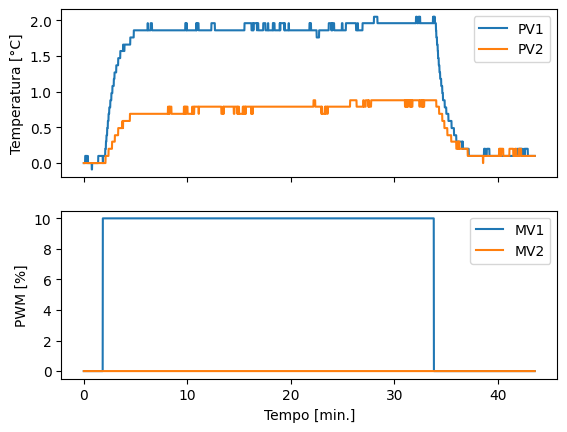

In [2]:
plot_pv_mv(dados1, f=remover_valor_inicial);

### Malha 2

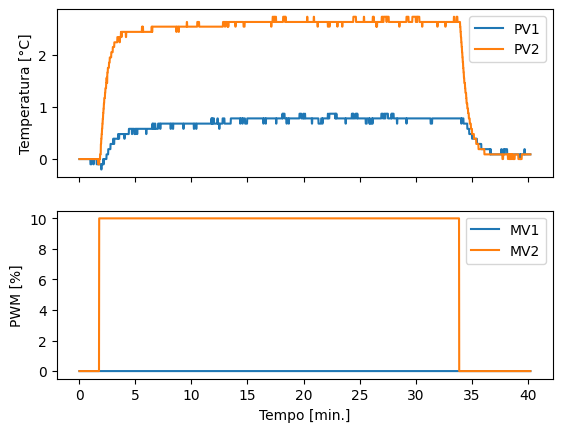

In [3]:
plot_pv_mv(dados2, f=remover_valor_inicial);

## 3. Resultados dos experimentos com Pertubação

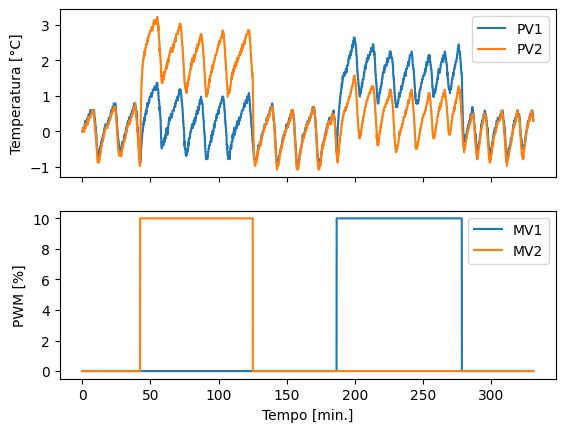

In [4]:
plot_pv_mv(dados1e2_pertubacao, f=remover_valor_inicial);

### Análise da pertubação



Amplitude da pertubação = 0.7299999999999986


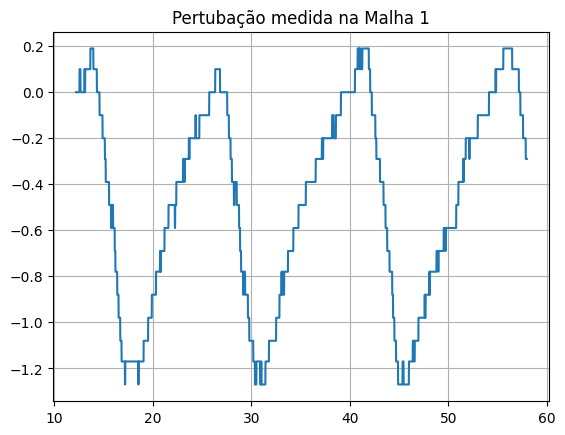

In [5]:
from matplotlib.widgets import Cursor
fig, ax = plt.subplots()
plt.title("Pertubação medida na Malha 1")
intervalo = (12*60, 12*60+15*60*3)
t_int = dados1_pertubado["t"][intervalo[0]:intervalo[1]]
pertubacao_malha1 = dados1_pertubado["pv1"][intervalo[0]:intervalo[1]]
plt.plot(t_int, remover_valor_inicial(pertubacao_malha1))
plt.grid(True)

amplitude_pertubacao1 = (max(pertubacao_malha1) - min(pertubacao_malha1)) * 0.5
print(f"Amplitude da pertubação = {amplitude_pertubacao1}")

cursor = Cursor(ax, useblit=True, color='red', linewidth=1)
# pontos = plt.ginput(2)
# t_subida = pontos[0][0]
# t_descida = pontos[1][0]
# print("Tempo de subida:", t_subida)
# print("Tempo de descida:", t_descida)

Do gráfico acima, é possível medir o tempo de subida, o período de oscilação e a amplitude do sinal.

- Tempo de subida medido: 10,53 minutos
- Período medido: 14,43 minutos
- Amplitude: 0,73 °C

Pode-se considerar que a influência em ambas as malhas são a mesma.

In [6]:
print("frequência pertubação:", 1/14.34/60)

frequência pertubação: 0.0011622501162250117


Frequência da componente 1: w_1 = 8.61029097650536 rad/s


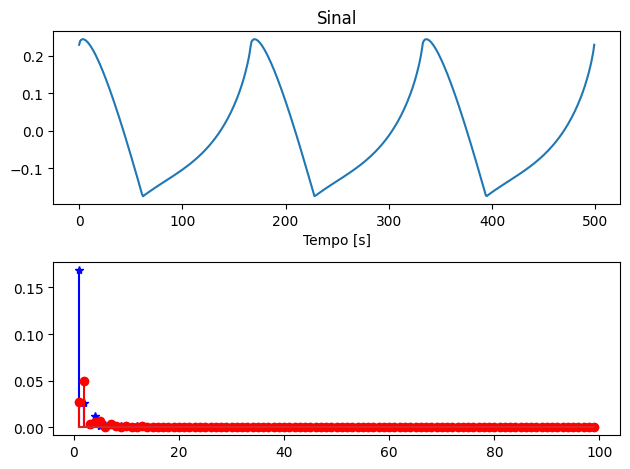

In [7]:
from sinais.serie_fourier.triangular import compute_coef

T = 10.53 * 60  # periodo
ts = 14.43 * 60 # tempo de subida
n_max = 100

i = list(range(1, n_max))
time = np.linspace(0, 3*T, 500)
sinal_coefs = list(map(lambda x: compute_coef(ts, T, x), i))
sinal_coefs = np.array(sinal_coefs)

sinal_triangular = 0
for n_i, [a_n, b_n] in enumerate(sinal_coefs):
    n_i = n_i + 1
    arg = 2*np.pi*n_i*time/T
    sinal_triangular += a_n*np.cos(arg) + b_n*np.sin(arg)

fig, (ax_sinal, ax_coefs) = plt.subplots(2, 1)

ax_sinal.set_title("Sinal")
ax_sinal.set_xlabel("Tempo [s]")
ax_sinal.plot(sinal_triangular)

# sinal_coefs = np.array()
ax_coefs.stem(i, sinal_coefs[:, 0], 'b', markerfmt='*b', label='$a_n$', use_line_collection=True)
ax_coefs.stem(i, sinal_coefs[:, 1], 'r', markerfmt='or', label='$b_n$', use_line_collection=True)

fig.tight_layout()

print(f"Frequência da componente 1: w_1 = {2*np.pi*ts/T} rad/s")

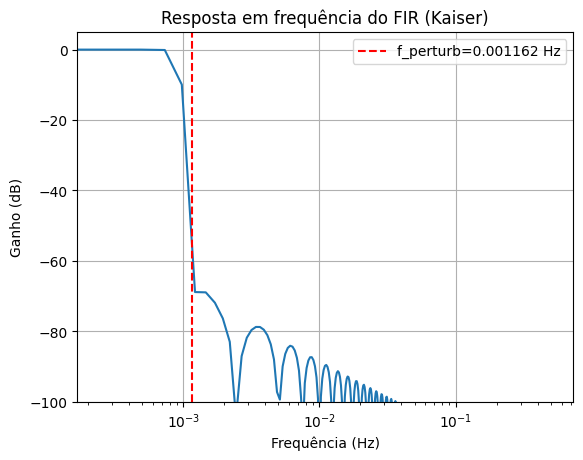

Ordem do filtro: 7791


In [21]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

def design_lowpass_fir_hz(f_p, fs=1.0, fp_ratio=0.8, fs_ratio=1.0, Ap=0.0, As=60.0):
    """
    Projeta um filtro FIR passa-baixa usando janela de Kaiser.
    
    Parâmetros:
    -----------
    f_p : float
        Frequência da perturbação em Hz (corte do filtro).
    fs : float
        Frequência de amostragem em Hz. Default: 1 Hz.
    fp_ratio : float
        Fração de f_p para a frequência de passagem (<=1). Default: 0.8
    fs_ratio : float
        Fração de f_p para a frequência de rejeição (>1). Default: 1.0
    Ap : float
        Ripple da banda de passagem (dB)
    As : float
        Atenuação da banda de rejeição (dB)
    
    Retorna:
    --------
    b : ndarray
        Coeficientes do filtro FIR.
    N_est : int
        Ordem estimada do filtro.
    """
    
    # Frequências de passagem e rejeição em Hz
    f_pass = fp_ratio * f_p
    f_stop = fs_ratio * f_p

    # Frequências normalizadas [0, 1], 1 = Nyquist
    fp_norm = f_pass / (fs/2)
    fs_norm = f_stop / (fs/2)

    # Estimativa da ordem via Kaiser
    Delta_f = fs_norm - fp_norm  # normalizada
    N_est = int(np.ceil((As - 8.0) / (2.285 * 2*np.pi*Delta_f)))
    if N_est % 2 == 0:
        N_est += 1  # preferir N ímpar para linear-phase

    # Beta da janela Kaiser
    if As > 50:
        beta = 0.1102*(As-8.7)
    elif As >= 21:
        beta = 0.5842*(As-21)**0.4 + 0.07886*(As-21)
    else:
        beta = 0.0

    # Projeto FIR
    b = signal.firwin(N_est, cutoff=f_pass, window=('kaiser', beta), fs=fs)

    return b, N_est

# design_lowpass_fir(w1=8.6, fs=1, Omega_p=0.8*8.6, Omega_s=0.9)
f_perturb = 0.00116225  # Hz
fs = 1.0                 # Hz
b, N_est = design_lowpass_fir_hz(f_perturb, fs)

# Resposta em frequência
w, H = signal.freqz(b, worN=2048, fs=fs)
H_db = 20*np.log10(np.abs(H))

plt.figure()
plt.semilogx(w, H_db)
plt.axvline(f_perturb, color='red', linestyle='--', label=f'f_perturb={f_perturb:.6f} Hz')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Ganho (dB)')
plt.title('Resposta em frequência do FIR (Kaiser)')
plt.legend()
plt.grid(True)
plt.ylim([-100, 5])
plt.show()

print("Ordem do filtro:", N_est)

In [12]:
H.shape

(2048,)

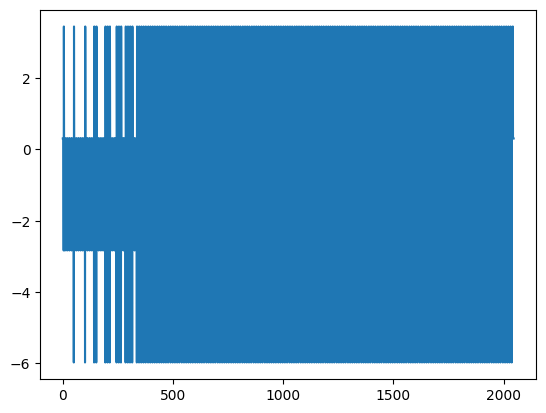

In [20]:
H_phase = np.arctan2(H.imag, H.real)
plt.plot(np.diff(H_phase))

# print(np.mean(np.diff(H_phase)))

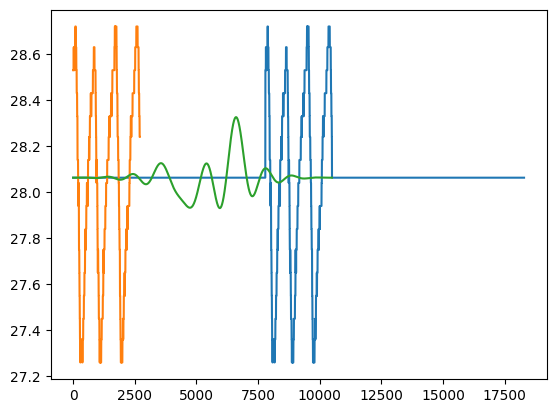

In [71]:
# x = dados1_pertubado['pv1']
x = pertubacao_malha1

mean_x = x.mean()

x_mod = np.concatenate([np.ones(len(b)) * mean_x, x, np.ones(len(b)) * mean_x])

ret = np.convolve(x_mod, b, 'valid')
# ret = signal.lfilter(b, 1, dados1_pertubado["pv1"])
plt.plot(x_mod)
plt.plot(x)
plt.plot(ret)

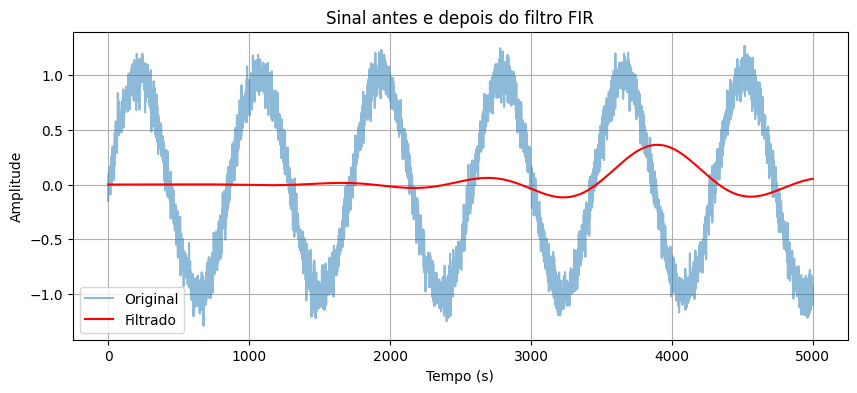

In [41]:
# --- Aplicar o FIR a um sinal no tempo ---
# Suponha que você já tenha um array `x` com o seu sinal

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Exemplo de sinal: você pode substituir pelo seu
# x = seu_sinal
t = np.arange(0, 5000)        # tempo em segundos
x = np.sin(2*np.pi*0.00116225*t) + 0.1*np.random.randn(len(t))  # sinal com ruído

# Aplicar filtro FIR (b do passo anterior)
# lfilter: causal, desloca a fase
# y = signal.lfilter(b, 1, x)

# filtfilt: zero-phase (recomendado para suavização)
y = signal.lfilter(b, 1, x)

# Plot
plt.figure(figsize=(10,4))
plt.plot(t, x, label='Original', alpha=0.5)
plt.plot(t, y, label='Filtrado', color='red')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Sinal antes e depois do filtro FIR')
plt.legend()
plt.grid(True)
plt.show()
